[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/guiwitz/MLCV/blob/main/notebooks/06-Training.ipynb)
# Training a network

Now that we know how to create a network, pass an input and an output, we only need to learn how to proceed for training and using it. Let's remember the different steps needed:

In [1]:
from IPython.display import Image

# set path containing data folder or use default for Colab (/gdrive/My Drive)
local_folder = "../"
import urllib.request
urllib.request.urlretrieve('https://raw.githubusercontent.com/guiwitz/MLCV/main/notebooks/check_colab.py', 'check_colab.py')
from check_colab import set_datapath
colab, datapath = set_datapath(local_folder)

Image(url='https://github.com/guiwitz/DLImaging/raw/master/illustrations/ML_principle.jpg',width=700)

1. First we will pass training examples *forward* through the network
2. We measure an error between prediction and true label, the loss
3. We calculate the gradient of the loss respective to each parameter in the model. This is done by *backpropagation*
4. We adjust the parameters using the calculated gradient and an optimizer (e.g. SGD)

Additionally we will also see in this notebooks additional aspects such as training epochs and validation. The goal here is to once see the whole pipeline in detail before we start using tools that reduce some of the boiler-plate code necessary here.

## Mini-batches

Before we create our network and define a loss, let's remember how training samples are passed through the network. In principle we want to do each optimization step for the **entire dataset** not just a single image as training would have a difficult time to converge. However this is usually not possible and and instead what is generally done is to use **mini-batches**, i.e. the network is iteratively trained on subsets of traininig examples. So now instead of using the gradients produced by a single image, one can use for example the average gradients over the mini-batch:

In [2]:
Image(url='https://github.com/guiwitz/DLImaging/raw/master/illustrations/batch_processing.jpg',width=700) 

As we have seen in the last chapter, PyTorch naturally takes batches as input. We just have to make sure we are passing the correct input (BCXY) and don't flatten the whole batch.

## Model and Data

Let's pick over from where we left in the last chapters and first create a small model:

In [54]:
import torch
from torch import nn
from torch.functional import F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import matplotlib.pyplot as plt

class Mynetwork(nn.Module):
    def __init__(self, input_size, num_categories):
        super(Mynetwork, self).__init__()
        
        # define e.g. layers here e.g.
        self.layer1 = nn.Linear(input_size, 10)
        self.layer2 = nn.Linear(10, num_categories)

    def forward(self, x):
        
        # flatten the input
        x = x.flatten(start_dim=1)
        # define the sequence of operations in the network including e.g. activations
        x = F.relu(self.layer1(x))
        x = self.layer2(x)
        
        return x

We also load a ```Dataset```, split it into a training and validation set and create the corresponding ```DataLoader``` objects:

In [55]:
# create transform to turn PIL to tensor
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

# load dataset
mnist = torchvision.datasets.MNIST(
    root='/Users/gw18g940/Desktop/Test_data_courses/MLCVdata/', 
    download=True, transform=transforms)

# split into test/validation
test_size = int(0.8 * len(mnist))
valid_size = len(mnist)-test_size
train_data, valid_data = random_split(mnist, [test_size, valid_size])

# create loaders
train_loader = DataLoader(dataset=train_data,batch_size=4)
validation_loader = DataLoader(dataset=valid_data,batch_size=4)

Let's look at a few samples:

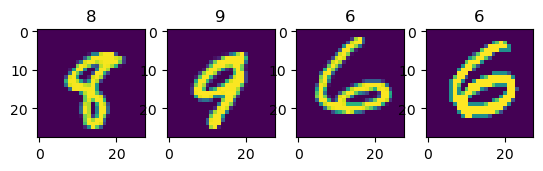

In [56]:
image_batch, image_labels = next(iter(train_loader))

fig, axes = plt.subplots(1,4)
for im, lab, ax in zip(image_batch, image_labels, axes):
    ax.imshow(im[0])
    ax.set_title(lab.item())

Let's pass a batch through our network:

In [57]:
model = Mynetwork(784, 10)

In [58]:
output = model(image_batch)
output

tensor([[ 0.2503, -0.2204,  0.1444,  0.3073,  0.0942,  0.1032,  0.0194,  0.0625,
         -0.0853, -0.0314],
        [ 0.2270, -0.2918,  0.1060,  0.3141, -0.0303,  0.0696, -0.0177,  0.0691,
         -0.0562, -0.0722],
        [ 0.2364, -0.2421,  0.1234,  0.2748,  0.0630,  0.1898,  0.0136,  0.1000,
         -0.0273, -0.0644],
        [ 0.2309, -0.2720,  0.1442,  0.3059,  0.0531,  0.1816,  0.0312,  0.0660,
         -0.0146, -0.0466]], grad_fn=<AddmmBackward0>)

## Basics of trainig

Now we have our input batch, the corresponding labels, and our output that we wish would predict the same labels. Our network is untrained, so obviously the labels cannot be correct, but at the moment we don't even have labels, just a bunch of floating point numbers. We could just take the maximum value as predicted label but then we would loose information. What we really want is to use all numbers to compute a **loss** (how far are we from the right answer). For multiple classes like here, this is typically done using the *cross-entropy*. PyTorch implements many different losses, including ```nn.CrossEntropyLoss``` which takes *directly the unnormalized values of the last layer (i.e. no need for soft-max, log etc.)*:


In [59]:
loss = nn.CrossEntropyLoss()

In [60]:
loss_value = loss(output, image_labels)
loss_value

tensor(2.3999, grad_fn=<NllLossBackward0>)

This is the value we want to optimize during training, i.e. we have to slightly tweak the weights of our network to improve the loss. To know in which direction to tweak, we need to compute the gradient of the loss with respect to all weights, i.e. perform **backpropagation**:

In [61]:
loss_value.backward()

Knowing the gradient, we need to apply the small shift to each weight. This  can be done in multiple ways with different **optimizers**. We use here the classical Adam optimizer which takes as input the model parameters and options such as the learning rate (how fast do we wat to optimize):

In [62]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=0.001)

Now that the optimizer is defined, we execture one step of optmization:

In [63]:
optimizer.step()

Then we reset the gradients (to avoid accumulating them):

In [64]:
optimizer.zero_grad()

And now we can start the whole process again with the next batch of images. While we use the cross-entropy to optimize the model, it is not a quantity that we can easily interpret. Instead we can computer e.g. the accuracy of our model. In the current case, we have an output:

In [65]:
output

tensor([[ 0.2503, -0.2204,  0.1444,  0.3073,  0.0942,  0.1032,  0.0194,  0.0625,
         -0.0853, -0.0314],
        [ 0.2270, -0.2918,  0.1060,  0.3141, -0.0303,  0.0696, -0.0177,  0.0691,
         -0.0562, -0.0722],
        [ 0.2364, -0.2421,  0.1234,  0.2748,  0.0630,  0.1898,  0.0136,  0.1000,
         -0.0273, -0.0644],
        [ 0.2309, -0.2720,  0.1442,  0.3059,  0.0531,  0.1816,  0.0312,  0.0660,
         -0.0146, -0.0466]], grad_fn=<AddmmBackward0>)

and we can get the current predicted label by looking for the location with the largest value:

In [66]:
output.argmax(axis=1)

tensor([3, 3, 3, 3])

Now we can compare this to the actual labels:

In [67]:
image_labels

tensor([8, 9, 6, 6])

and compute the accuracy, essentially which labels are the same:

In [68]:
((output.argmax(axis=1) - image_labels) == 0).sum()

tensor(0)

Currently that value is zero or low but hopefully after a few steps it would improve!

## Training loop

Our training will looks something like this now:

```
for batch in dataset:
    compute a prediction and its loss
    do a around of optimization
    compute the current accuracy
    
    every nth iteration:
        compute the accuracy on the validation dataset
```

With basic PyTorch, this is relatively tedious to write (e.g. you should not forget zeroing the gradients, have for loops for batches etc. So several higher level libraries simplify this process. We use here the PyTorch-lightning library which stick very closely to PyTorch but brings many simplifications.

The idea is essentially to skip having to write loops. Instead, we'll just specify what is supposed to happen at each iteration (e.g. compute accuracy) and PyTorch lightning will take care for us to go over all batches, zero the optimizer etc. For this we just have to add a few things to our model, which is now a subclass of the lightning module instead of the base module:

In [69]:
import pytorch_lightning as pl

In [70]:
class Mynetwork_pl(pl.LightningModule):
    def __init__(self, input_size, num_categories):
        super(Mynetwork_pl, self).__init__()
        
        # define e.g. layers here e.g.
        self.layer1 = nn.Linear(input_size, 10)
        self.layer2 = nn.Linear(10, num_categories)
        
        self.loss = nn.CrossEntropyLoss()

    def forward(self, x):
        
        # flatten the input
        x = x.flatten(start_dim=1)
        # define the sequence of operations in the network including e.g. activations
        x = F.relu(self.layer1(x))
        x = self.layer2(x)
        
        return x
    
    def training_step(self, batch, batch_idx):
        
        x, y = batch
        output = self(x)
        loss = self.loss(output, y)
        
        self.log('loss', loss, on_epoch=True, prog_bar=True, logger=True)

        return loss
    
    def validation_step(self, batch, batch_idx):
        
        x, y = batch
        output = self(x)
        accuracy = (torch.argmax(output,dim=1) == y).sum()/len(y)

        self.log('accuracy', accuracy, on_epoch=True, prog_bar=True, logger=True)
        
        return accuracy
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)


In [71]:
del model
model = Mynetwork_pl(784, 10)

We see that we have now added the loss definition in the ```__init__``` function and just added three functions:
- one that says what happens at each training step: computing and returning the loss
- one that says what happens at each validation step: compute the accuracy
- finally the optimizer is defined in ```configure_optimizers```

## Training

Now we can finally train the network. For that we use a lightning ```Trainer``` which is the object that will perform the loops, batching etc. We only have to specify how many times we want to go over the entire dataset (epochs):

In [72]:
from pytorch_lightning.trainer import Trainer

In [73]:
trainer = pl.Trainer(max_epochs=5, enable_progress_bar=False)
#trainer = pl.Trainer(max_epochs=10), accelerator='gpu') #on Colab or GPU
#trainer = pl.Trainer(max_epochs=10), accelerator='mps') #on mac m1

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/gw18g940/mambaforge/envs/CASImaging2023/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:200: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Then we can run the training by specifying which dataset to use and which model:

In [74]:
train_loader = DataLoader(dataset=train_data, batch_size=20, num_workers=8)
validation_loader = DataLoader(dataset=valid_data, batch_size=20, num_workers=8)

In [75]:
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=validation_loader)


  | Name   | Type             | Params
--------------------------------------------
0 | layer1 | Linear           | 7.9 K 
1 | layer2 | Linear           | 110   
2 | loss   | CrossEntropyLoss | 0     
--------------------------------------------
8.0 K     Trainable params
0         Non-trainable params
8.0 K     Total params
0.032     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=5` reached.


## Logging

By default Lightning logs the data for us in a format compatible with tensorflow (but we could use other loggers too). We can simply visualize the progress in a notebook using:

In [45]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 14013), started 0:04:23 ago. (Use '!kill 14013' to kill it.)

## Checking quality

We can now take a sample from the validation data to explore how well our model does:

In [76]:
val_data, val_label = next(iter(validation_loader))

In [77]:
model(val_data).argmax(axis=1)

tensor([0, 3, 2, 7, 0, 4, 0, 8, 8, 0, 0, 1, 3, 4, 9, 9, 7, 1, 3, 0])

In [78]:
val_label

tensor([0, 5, 2, 7, 0, 4, 0, 8, 8, 0, 0, 1, 3, 4, 9, 9, 7, 1, 3, 0])

More generally we can try to investigate where our model makes mistakes. Let's run predictions for the whole validation dataset:

In [79]:
pred = []
real_lab = []
for im, lab in validation_loader:
    out = model(im)
    pred.append(out.argmax(axis=1))
    real_lab.append(lab)
    
prediction = torch.concatenate(pred)
real_label = torch.concatenate(real_lab)

Now we can compare the actual vs. predicted labels in a confusion matrix. We use here the scikit-learn implementation and plot the result using seaborn:

In [80]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import seaborn as sns

In [81]:
df_cm = pd.DataFrame(confusion_matrix(prediction, real_label), index = np.arange(0,10),
                  columns = np.arange(0,10))

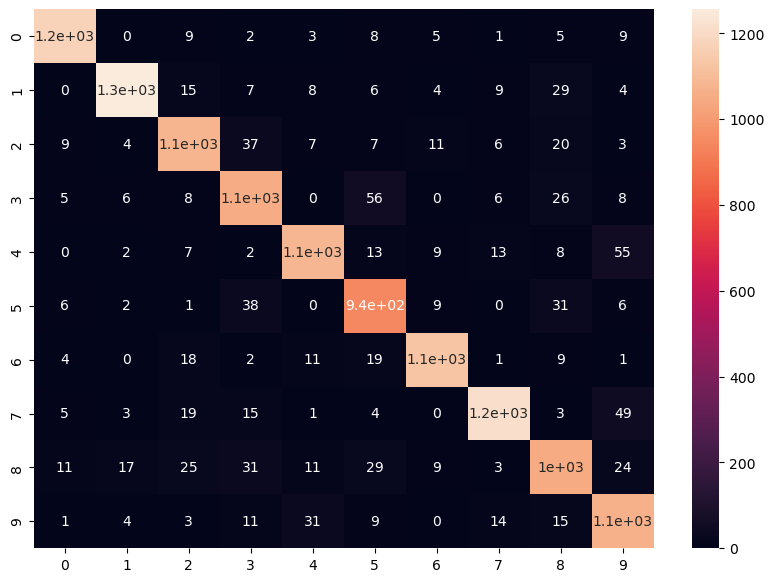

In [82]:
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True);

We see that most numbers are classified correctly (diagonal). We also see that e.g. 3 and 8 are often mixed up which makes sense give their similarity. Now we can investigate in which case the classification fails by looking at bad examples:

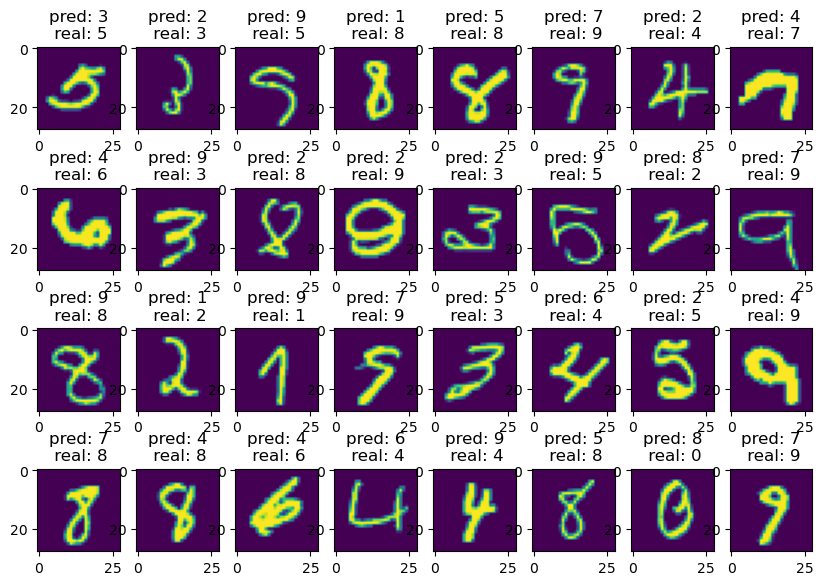

In [86]:
error_index = torch.argwhere((prediction-real_label) != 0)

fig, axes = plt.subplots(4,8,figsize=(10,7))

for ind, ax in zip(error_index, axes.ravel()):
    ax.imshow(valid_data[ind][0][0])
    ax.set_title(f'pred: {prediction[ind].item()}\n real: {real_label[ind].item()}')

Clearly most of these bad examples are outliers!

## Exercise

Try to train the a similar network as done here but on the quickdraw dataset for which you have already created a data loader in the previous exercise.